In [ ]:
# 30일치 데이터 합치기
import pandas as pd

target_date = ['2022-06-01', '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07', '2022-06-08', '2022-06-09', '2022-06-10',
               '2022-06-11', '2022-06-12', '2022-06-13', '2022-06-14', '2022-06-15',
               '2022-06-16', '2022-06-17', '2022-06-18', '2022-06-19', '2022-06-20',
               '2022-06-21', '2022-06-22', '2022-06-23', '2022-06-24', '2022-06-25',
               '2022-06-26', '2022-06-27', '2022-06-28', '2022-06-29', '2022-06-30']

folder_path_3 = "C:/sh/study/krx데이콘/krx_2022/sh/data/score"

for date in target_date:
  df_day = pd.read_csv(folder_path_3 + "/" + date + "_score.csv")[["날짜","score"]]
  df_day = df_day[df_day["날짜"] == date]
  df_mean = df_day.groupby("날짜").mean()
  df_mean["score"].iloc[0] = (df_mean["score"].iloc[0]/2) + 50
  print(df_mean)
  if target_date.index(date) == 0:
    df_score = df_mean
  else:
    df_score = pd.concat([df_score,df_mean])

## fear/greed 점수 뽑기
+ 각 요소의 weight를 인자로 받음
+ 만약 nan값이면 그 만큼의 weight를 score에 증가시킴

In [54]:
from cProfile import label
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
import numpy as np
from regex import R

# file_path = final data의 경로
# score_weight = 비정형 데이터의 weihgt
# exchange_weight = 환율의 weight
# transaction_weight = 거래 회전율의 weight
# round = 소수 둘째자리까지 반올림하냐마냐
# score = score값을 그래프에 추가하냐 마냐
# exchange = 환율을 그래프에 추가하냐 마냐
# trasaction = 거래회전율을 그래프에 추가하냐 마냐

def make_graph(file_path,score_weight,exchange_weight,transaction_weight, round = False, score = False, exchange = False, transaction = False):
    # 점수 불러오기
    df_score = pd.read_csv("final.csv")[["날짜","거래회전율","환율","score"]]
    df_score.set_index("날짜",inplace=True)

    # pykrx정보 불러오기
    df_stock = stock.get_index_fundamental("20220601", "20220630", "1001")
    df_stock["날짜"] = df_stock.index.astype("str")
    df_stock.set_index("날짜",inplace=True)

    # weight에 따라 fg_score 계산
    fg_score = []
    for i in range(30):
        sc = df_score["score"].iloc[i]
        ex = df_score["환율"].iloc[i]
        tr = df_score["거래회전율"].iloc[i]
        sw = score_weight
        ew = exchange_weight
        tw = transaction_weight
        if np.isnan(ex):
            sw += ew
            ex = 0
        if np.isnan(tr):
            sw += tw
            tr = 0
        fg = (sc*sw) + (ex*ew) + (tr*tw)
        # 반올림
        if round:
            fg = np.round(fg,2)
        fg_score.append(fg)
    

    # dataframe에 넣기
    df_score["fg_score"] = fg_score

    # 그래프 그리기
    plt.figure(figsize=(12,8))
    plt.plot(df_score["fg_score"],label = "fear/greed score")
    if score:
        plt.plot(df_score["score"],label = "score")
    if exchange:
        plt.plot(df_score["환율"],label = "환율")
    if transaction:
        plt.plot(df_score["거래회전율"],label = "거래회전율")
    plt.legend()
    plt.title("fear/greed score per day", color = "white",size = 20)
    plt.xticks(range(0,30,2), rotation = 30, size = 13)
    plt.yticks(size = 13)
    plt.tick_params(color = 'white',colors = 'white')

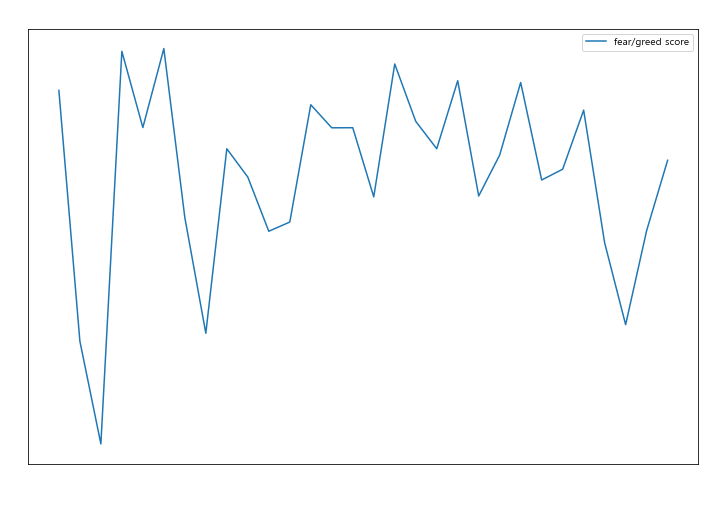

In [60]:
# 기본 사용 형태
make_graph("final.csv",
           score_weight=0.5,            # score의 가중치
           exchange_weight=0.25,        # 환율의 가중치
           transaction_weight=0.25,     # 거래회전율의 가중치
           round=False,                 # 반올림을 소수 둘째자리까지 할것인지 말것인지
           score=False,                 # score의 그래프를 추가할지 말지
           exchange=False,              # 환율의 그래프를 추가할지 말지
           transaction=False,)          # 거래회전율의 그래프를 추가할지 말지